## Authors: Benjamin Barinka, Snigdhayan Mahanta, Matthias Semmelmann (in alphabetical order of last name)

In this notebook we use tensorflow-quantum to train a quantum neural network (QNN) model for breast cancer analysis. We use the freely available breast cancer dataset (with labels) for this purpose. To reduce complexity we have restricted our attention to the top 4 most relevant features. This was ascertained separately via 'feature selection'. After standard preprocessing we prepared two training datasets as follows:

1. Superposition input approach - each feature is modeled by one qubit. After rescaling all input values are between 0 and 1. So we apply the 'rotation along y-axis' proportional to the input value to each qubit state.
2. Binary input approach - each feature is modeled by one qubit. After rescaling all input values are between 0 and 1. We define an intermediate theshold value and map each input value less than the threshold value to 0 and greater than the threshold value to 1. In this manner we obtain a binary input dataset and then we apply the X-gate to those qubits, whose corresponding input value is one.

Finally, we adapt the QNN construction in this tutorial https://www.tensorflow.org/quantum/tutorials/mnist to our setting and compare the results of the two approaches.

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import time
import cirq
import sympy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
# The breast cancer dataset can be obtained from here - https://github.com/snigdhayan/NeuralNetworks/blob/master/Ludwig/breast_cancer_dataset.csv
df = pd.read_csv('./breast_cancer_dataset.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
scaling_table = {}
for column in df:
    column_max = df[column].max()
    column_min = df[column].min()
    df[column] = (df[column] - column_min) / (column_max - column_min)
    scaling_table[column] = {'min': column_min, 'max': column_max}
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,label
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0


In [4]:
y_columns = df['label'].values
THRESHOLD = 0.5

worst_concave_points = df['worst_concave_points']
worst_perimeter = df['worst_perimeter']
mean_concave_points = df['mean_concave_points']
worst_radius = df['worst_radius']

worst_concave_points_bin = df['worst_concave_points'].apply(lambda x : 0 if x < THRESHOLD else 1)
worst_perimeter_bin = df['worst_perimeter'].apply(lambda x : 0 if x < THRESHOLD else 1)
mean_concave_points_bin = df['mean_concave_points'].apply(lambda x : 0 if x < THRESHOLD else 1)
worst_radius_bin = df['worst_radius'].apply(lambda x : 0 if x < THRESHOLD else 1)

sel_df = pd.concat([worst_concave_points, worst_perimeter, mean_concave_points, worst_radius], axis=1)
sel_df.rename(columns={0: 'wcp', 1: 'wp', 2: 'mcp', 3: 'wr'}, inplace=True)

sel_df_bin = pd.concat([worst_concave_points_bin, worst_perimeter_bin, mean_concave_points_bin, worst_radius_bin], axis=1)#pd.concat([mean,error,worst], axis=1)
sel_df_bin.rename(columns={0: 'wcp', 1: 'wp', 2: 'mcp', 3: 'wr'}, inplace=True)


In [5]:
train_test_split = 400
y_train = y_columns.reshape(1,-1)[0]
y_test = y_train[train_test_split:]
y_train = y_train[:train_test_split]

x_train = sel_df.values
x_test = x_train[train_test_split:]
x_train = x_train[:train_test_split]

x_train_bin = sel_df_bin.values
x_test_bin = x_train_bin[train_test_split:]
x_train_bin = x_train_bin[:train_test_split]


In [6]:
def convert_to_circuit(data):
    """Encode prepared data into quantum datapoint."""
    values = np.ndarray.flatten(data)
    qubits = cirq.GridQubit.rect(4, 1)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        rad = (value) * np.pi
        circuit.append(cirq.ry(rad)(qubits[i]))
            
    return circuit

In [7]:
def convert_to_circuit_bin(data):
    """Encode prepared data into quantum datapoint."""
    values = np.ndarray.flatten(data)
    qubits = cirq.GridQubit.rect(4, 1)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value == 1:
            circuit.append(cirq.X(qubits[i]))
            
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


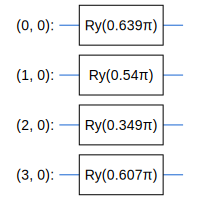

In [8]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

SVGCircuit(x_train_circ[1])

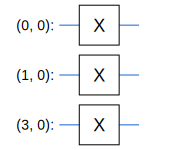

In [9]:
x_train_circ_bin = [convert_to_circuit_bin(x) for x in x_train_bin]
x_test_circ_bin = [convert_to_circuit_bin(x) for x in x_test_bin]

SVGCircuit(x_train_circ_bin[1])

In [10]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

x_train_tfcirc_bin = tfq.convert_to_tensor(x_train_circ_bin)
x_test_tfcirc_bin = tfq.convert_to_tensor(x_test_circ_bin)

In [11]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [12]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [13]:
model_circuit, model_readout = create_quantum_model()

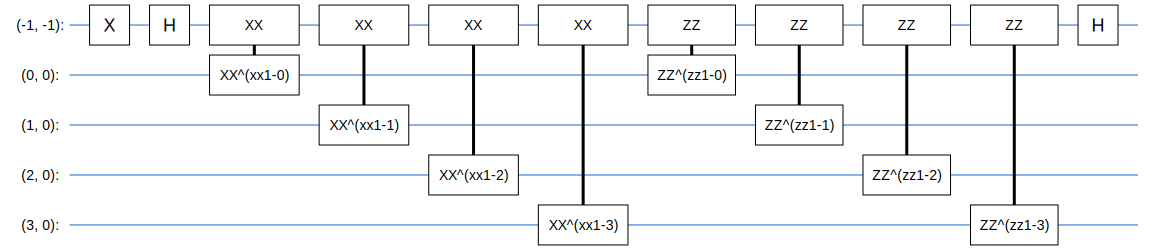

In [14]:
SVGCircuit(model_circuit)

In [15]:
# Build the Keras model.
qnn_model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [16]:
# Build the Keras model.
qnn_model_bin = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [17]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [18]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [19]:
qnn_model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
qnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [20]:
qnn_model_bin.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
qnn_model_bin.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 5
BATCH_SIZE = 8

NUM_EXAMPLES = len(x_train_tfcirc)

In [22]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [23]:
x_train_tfcirc_sub_bin = x_train_tfcirc_bin[:NUM_EXAMPLES]
y_train_hinge_sub_bin = y_train_hinge[:NUM_EXAMPLES]

In [24]:
start_time = time.time()
qnn_history = qnn_model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = qnn_model.evaluate(x_test_tfcirc, y_test)
qnn_training_time = time.time() - start_time

Epoch 1/5
50/50 [==============================] - 1s 11ms/step - loss: 1.2379 - hinge_accuracy: 0.4225 - val_loss: 1.3314 - val_hinge_accuracy: 0.2159
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 1.0971 - hinge_accuracy: 0.4250 - val_loss: 1.0614 - val_hinge_accuracy: 0.3239
Epoch 3/5
50/50 [==============================] - 0s 7ms/step - loss: 0.9137 - hinge_accuracy: 0.7475 - val_loss: 0.8111 - val_hinge_accuracy: 0.8864
Epoch 4/5
50/50 [==============================] - 0s 7ms/step - loss: 0.7856 - hinge_accuracy: 0.8525 - val_loss: 0.6896 - val_hinge_accuracy: 0.9318
Epoch 5/5
6/6 [==============================] - 0s 8ms/step - loss: 0.6465 - hinge_accuracy: 0.8872


In [25]:
start_time = time.time()
qnn_history_bin = qnn_model_bin.fit(
      x_train_tfcirc_sub_bin, y_train_hinge_sub_bin,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc_bin, y_test_hinge))

qnn_results_bin = qnn_model.evaluate(x_test_tfcirc_bin, y_test)
qnn_training_time_bin = time.time() - start_time

Epoch 1/5
50/50 [==============================] - 0s 10ms/step - loss: 1.2091 - hinge_accuracy: 0.2700 - val_loss: 1.3352 - val_hinge_accuracy: 0.1420
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 1.1339 - hinge_accuracy: 0.2925 - val_loss: 1.1908 - val_hinge_accuracy: 0.1420
Epoch 3/5
50/50 [==============================] - 0s 6ms/step - loss: 1.0396 - hinge_accuracy: 0.3075 - val_loss: 0.9970 - val_hinge_accuracy: 0.8295
Epoch 4/5
50/50 [==============================] - 0s 6ms/step - loss: 0.9260 - hinge_accuracy: 0.6975 - val_loss: 0.7820 - val_hinge_accuracy: 0.8295
Epoch 5/5
6/6 [==============================] - 0s 7ms/step - loss: 0.3539 - hinge_accuracy: 0.8189


Text(0.5, 1.0, 'Hinge Accuracy Score')

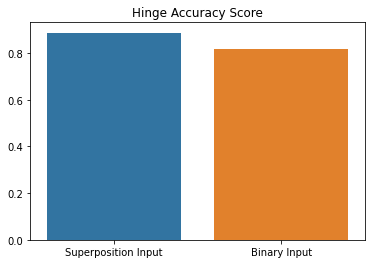

In [26]:
qnn_accuracy = qnn_results[1]
qnn_accuracy_bin = qnn_results_bin[1]
sns.barplot(x=['Superposition Input','Binary Input'],y=[qnn_accuracy,qnn_accuracy_bin])
plt.title('Hinge Accuracy Score')

Text(0.5, 1.0, 'Training Time (in seconds)')

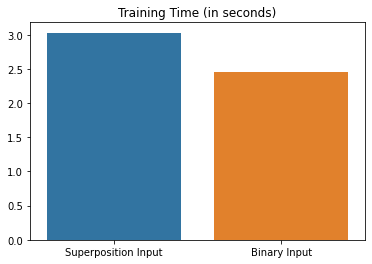

In [27]:
superposition_training_time = round(qnn_training_time,2)
binary_training_time = round(qnn_training_time_bin,2)

sns.barplot(x=['Superposition Input','Binary Input'],y=[superposition_training_time,binary_training_time])
plt.title('Training Time (in seconds)')

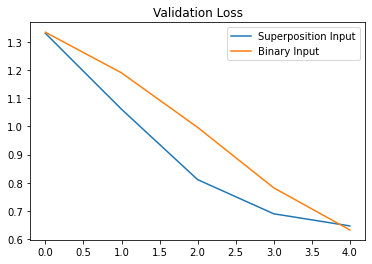

In [28]:
plt.plot(qnn_history.history['val_loss'], label='Superposition Input')
plt.plot(qnn_history_bin.history['val_loss'], label='Binary Input')
plt.title('Validation Loss')
plt.legend(('Superposition Input', 'Binary Input'))

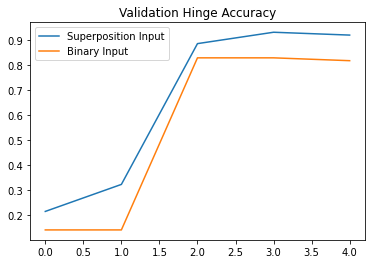

In [29]:
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.plot(qnn_history_bin.history['val_hinge_accuracy'])
plt.title('Validation Hinge Accuracy')
plt.legend(('Superposition Input', 'Binary Input'))